In [3]:
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
import pickle
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import networkx as nx

from data_conversions import selectData, transformData
from data_conversions import floatifyData, boolifyData, quantizeData
from sampling import mkSamps, toHisto, toProbV
from sampling import createSparseBinner as createBinner
from metropolis import mutualInfo, genMetropolisSamples
from agent_based_model import createWeightedSamplesGenerator, select_subset, createWeightSer, lnLik
from agent_based_model import load_dataset
from estimate_generic_guide_func import minimizeMe, weightedSampGen
from mutator import MSTMutator

In [4]:
    subDF, acesL, boolColL, scalarColL, fixedL, passiveL, ageL = load_dataset()

    ageMin = int(min(ageL))
    ageMax = int(max(ageL))
    scalarColL.remove('AGE')
    print('scalar columns: ', scalarColL)
    ageDFD = {}
    range_d = None
    for age in range(ageMin, ageMax+1):
        ageDF = subDF[subDF.AGE==age].drop(columns=['AGE', 'FIPSST'])
        ageDFD[age], _, _, _, dct = quantizeData(ageDF, acesL, boolColL, scalarColL)
        if range_d is None:
            range_d = dct
        else:
            assert dct == range_d, 'Quantized ranges do not match?'    
            

Index(['FIPSST', 'HHID', 'FORMTYPE', 'TOTKIDS_R', 'HHLANGUAGE', 'SC_AGE_YEARS',
       'SC_SEX', 'K2Q35A_1_YEARS', 'MOMAGE', 'K6Q41R_STILL',
       ...
       'BIRTHWT', 'CBSAFP_YN', 'FWC', 'CURRINS', 'INSTYPE', 'HOUSE_GEN',
       'HHSIZE_I', 'HHSIZE_IF', 'FPL_IF', 'INSGAP'],
      dtype='object', length=422)
scalar columns:  ['BIRTHORDER', 'FPL', 'MOMAGE', 'TOTACES', 'TOTCSHCN', 'TOTKIDS']


In [5]:
print(subDF['TOTACES'].count())

3388


In [6]:
print(subDF[subDF.TOTACES >= 5]['TOTACES'].count())
print(70./3388.)

70
0.02066115702479339


In [94]:
age = 16
src = 'deep_poor_black_male_generic_guides/%d-%d_generic.pkl' % (age, age+1)
seed_file = 'poor_black_male.pkl'
N_SAMP = 100
N_ITER = 1000


In [95]:
with open(src, 'rb') as f:
    rslt, pair_l = pickle.load(f)
print(pair_l)

[[array([0.3432833 , 0.97838672, 0.3566947 , 0.70469128, 0.98720897,
       0.75896951, 0.40766516, 0.5657818 , 0.15262393, 0.02697542,
       0.04751967, 0.0775623 ]), 0.5117272939300421, 1.1265478482609572], [array([0.3432833 , 0.97838672, 0.3566947 , 0.70469128, 0.98720897,
       0.75896951, 0.40766516, 0.5657818 , 0.15262393, 0.02697542,
       0.04751967, 0.0775623 ]), 0.5725981841081321, 1.1262192212128275], [array([0.50420679, 0.77063649, 0.88078128, 0.78658799, 0.62373393,
       0.16323084, 0.13468697, 0.75009445, 0.30604193, 0.1588443 ,
       0.02525514, 0.10572241]), 0.6194922021059976, 1.1006982739076423], [array([0.52782259, 0.78712115, 0.85909871, 0.49116822, 0.82856121,
       0.20614152, 0.59748696, 0.95801296, 0.71529026, 0.13778061,
       0.01957272, 0.09982427]), 0.6540668077275231, 1.1734021899446687], [array([0.52782259, 0.78712115, 0.85909871, 0.49116822, 0.82856121,
       0.20614152, 0.59748696, 0.95801296, 0.71529026, 0.13778061,
       0.01957272, 0.0998242

In [96]:
conv_l = []
xv_l = []
mi_l = []
for xv, conv, mi in pair_l:
    conv_l.append(conv)
    xv_l.append(xv)
    mi_l.append(mi)

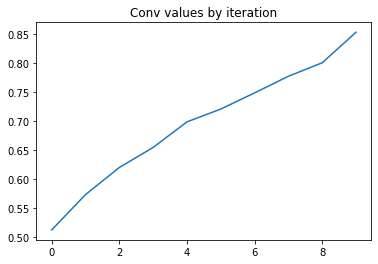

In [97]:
plt.title('Conv values by iteration')
plt.plot(*zip(*enumerate(conv_l)))
plt.show()

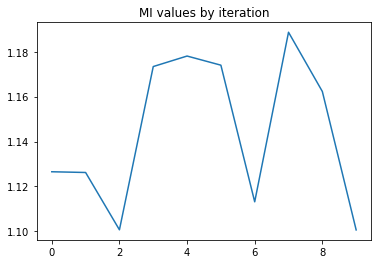

In [98]:
plt.title('MI values by iteration')
plt.plot(*zip(*enumerate(mi_l)))
plt.show()

In [109]:
prototype = weightedSampGen(pd.read_pickle(seed_file), 1)

fixed_l = fixedL
fixed_d = {elt: prototype.iloc[0][elt] for elt in fixed_l}
passive_l = passiveL
aces_l = acesL
advancing_l = [elt for elt in aces_l if elt not in list(fixed_d) + passive_l]
open_l = [k for k in prototype.columns]
for elt in list(fixed_d) + advancing_l + passive_l:
    open_l.remove(elt)
samp_gen = weightedSampGen
all_col_l = open_l + advancing_l
which_bin = createBinner(all_col_l, range_d=range_d)
binnerParams = {}


createBinner: colL =  ['BIRTHWT_L', 'CLUBS', 'DENTALCARE', 'DOCTORVISIT', 'HHLANGUAGE_SPANISH', 'SC_CSHCN', 'SPORTSTEAMS', 'VISIONCARE', 'BIRTHORDER_minusone', 'FPL', 'TOTKIDS_minusone']


In [110]:
std_fixed_d = fixed_d.copy()
fixed_d['SC_FEMALE'] = 0
fixed_d['SC_RACE_WHITE'] = 1
fixed_d['SC_RACE_BLACK'] = 0
print(fixed_d)

{'BIRTHWT_VL': 0, 'PREMATURE': 0, 'HHLANGUAGE_ENGLISH': 1, 'SC_FEMALE': 0, 'SC_RACE_NATIVE': 0, 'SC_RACE_ASIAN': 0, 'SC_RACE_ISLANDS': 0, 'SC_RACE_OTHER': 0, 'SC_RACE_MIXED': 0, 'SC_RACE_HISPANIC': 0, 'MOMAGE_LT_20': 0, 'MOMAGE_GT_39': 0, 'SC_RACE_WHITE': 1, 'SC_RACE_BLACK': 0}


In [111]:
for age in range(ageMin, ageMax+1):
    ageDF = ageDFD[age]
    print('---------- age %d ----------' % age)
    cohort = select_subset(ageDF, fixed_d)
    display(cohort[cohort.TOTACES >= 2])

---------- age 6 ----------
begin select_subset: 223 records, 223 unique
BIRTHWT_VL == 0: 220 entries, 220 unique
PREMATURE == 0: 188 entries, 188 unique
HHLANGUAGE_ENGLISH == 1: 175 entries, 175 unique
SC_FEMALE == 0: 77 entries, 77 unique
SC_RACE_NATIVE == 0: 77 entries, 77 unique
SC_RACE_ASIAN == 0: 72 entries, 72 unique
SC_RACE_ISLANDS == 0: 72 entries, 72 unique
SC_RACE_OTHER == 0: 71 entries, 71 unique
SC_RACE_MIXED == 0: 70 entries, 70 unique
SC_RACE_HISPANIC == 0: 65 entries, 65 unique
MOMAGE_LT_20 == 0: 62 entries, 62 unique
MOMAGE_GT_39 == 0: 55 entries, 55 unique
SC_RACE_WHITE == 1: 47 entries, 47 unique
SC_RACE_BLACK == 0: 47 entries, 47 unique


,FWC,RECIDX,DRUGSALCOHOL,MENTALILL,PARENTDIED,PARENTDIVORCED,PARENTJAIL,RACISM,SEEPUNCH,VIOLENCE,...,SC_RACE_WHITE,SPORTSTEAMS,VISIONCARE,BIRTHORDER_minusone,FPL,MOMAGE_LT_20,MOMAGE_GT_39,TOTACES,TOTCSHCN,TOTKIDS_minusone
857,487.504909,12202,1,1,0,1,0,0,1,1,...,1,0,1,0,4,0,0,5,1,0
1055,4383.963337,15602,1,0,0,0,1,0,0,0,...,1,1,1,1,0,0,0,2,1,1
1349,1281.456511,19797,1,1,0,1,1,1,1,1,...,1,0,0,0,4,0,0,7,1,0
3004,17081.302555,44297,0,0,0,1,1,0,0,0,...,1,0,0,3,0,0,0,2,0,3


---------- age 7 ----------
begin select_subset: 230 records, 230 unique
BIRTHWT_VL == 0: 227 entries, 227 unique
PREMATURE == 0: 209 entries, 209 unique
HHLANGUAGE_ENGLISH == 1: 199 entries, 199 unique
SC_FEMALE == 0: 88 entries, 88 unique
SC_RACE_NATIVE == 0: 87 entries, 87 unique
SC_RACE_ASIAN == 0: 86 entries, 86 unique
SC_RACE_ISLANDS == 0: 86 entries, 86 unique
SC_RACE_OTHER == 0: 86 entries, 86 unique
SC_RACE_MIXED == 0: 76 entries, 76 unique
SC_RACE_HISPANIC == 0: 72 entries, 72 unique
MOMAGE_LT_20 == 0: 71 entries, 71 unique
MOMAGE_GT_39 == 0: 67 entries, 67 unique
SC_RACE_WHITE == 1: 59 entries, 59 unique
SC_RACE_BLACK == 0: 59 entries, 59 unique


,FWC,RECIDX,DRUGSALCOHOL,MENTALILL,PARENTDIED,PARENTDIVORCED,PARENTJAIL,RACISM,SEEPUNCH,VIOLENCE,...,SC_RACE_WHITE,SPORTSTEAMS,VISIONCARE,BIRTHORDER_minusone,FPL,MOMAGE_LT_20,MOMAGE_GT_39,TOTACES,TOTCSHCN,TOTKIDS_minusone
105,2050.007378,1460,1,1,0,1,1,0,1,0,...,1,1,1,3,1,0,0,5,1,3
278,1133.546583,3852,1,0,0,1,1,0,0,0,...,1,1,1,2,4,0,0,3,0,1
490,3201.597858,6866,1,1,1,1,1,0,0,0,...,1,0,0,4,1,0,0,5,0,3
1314,994.174401,19318,1,0,0,0,1,0,0,0,...,1,1,0,1,4,0,0,2,2,1
1446,1732.377546,21158,0,0,1,1,0,0,0,0,...,1,1,0,2,3,0,0,2,0,1
2264,762.472006,33224,0,1,1,0,0,0,0,0,...,1,0,1,2,4,0,0,2,0,1
2640,2499.361029,39054,0,0,0,1,1,0,0,0,...,1,1,1,2,0,0,0,2,2,3
2874,2546.418684,42445,0,0,0,1,0,0,0,1,...,1,1,1,0,2,0,0,2,0,0
3056,2034.020908,45114,0,1,0,0,0,0,1,0,...,1,1,0,2,3,0,0,2,0,1


---------- age 8 ----------
begin select_subset: 258 records, 258 unique
BIRTHWT_VL == 0: 247 entries, 247 unique
PREMATURE == 0: 216 entries, 216 unique
HHLANGUAGE_ENGLISH == 1: 208 entries, 208 unique
SC_FEMALE == 0: 109 entries, 109 unique
SC_RACE_NATIVE == 0: 109 entries, 109 unique
SC_RACE_ASIAN == 0: 105 entries, 105 unique
SC_RACE_ISLANDS == 0: 105 entries, 105 unique
SC_RACE_OTHER == 0: 105 entries, 105 unique
SC_RACE_MIXED == 0: 96 entries, 96 unique
SC_RACE_HISPANIC == 0: 90 entries, 90 unique
MOMAGE_LT_20 == 0: 83 entries, 83 unique
MOMAGE_GT_39 == 0: 77 entries, 77 unique
SC_RACE_WHITE == 1: 56 entries, 56 unique
SC_RACE_BLACK == 0: 56 entries, 56 unique


,FWC,RECIDX,DRUGSALCOHOL,MENTALILL,PARENTDIED,PARENTDIVORCED,PARENTJAIL,RACISM,SEEPUNCH,VIOLENCE,...,SC_RACE_WHITE,SPORTSTEAMS,VISIONCARE,BIRTHORDER_minusone,FPL,MOMAGE_LT_20,MOMAGE_GT_39,TOTACES,TOTCSHCN,TOTKIDS_minusone
392,1292.017851,5401,0,0,0,1,0,0,0,1,...,1,0,0,1,1,0,0,2,0,1
407,976.965165,5589,1,1,0,0,0,0,0,0,...,1,1,0,2,0,0,0,2,1,1
801,722.661204,11329,1,1,0,1,1,0,0,0,...,1,0,0,0,0,0,0,4,0,0
1065,650.737255,15729,1,1,0,1,1,0,1,0,...,1,0,0,0,1,0,0,5,0,0
1687,1720.996291,24845,1,0,1,1,0,0,0,0,...,1,1,0,0,4,0,0,3,1,0
2403,1135.967821,35229,0,0,0,1,1,0,1,0,...,1,0,1,2,0,0,0,3,2,2
3071,287.388770,45255,1,0,0,1,1,0,1,1,...,1,1,1,0,4,0,0,5,1,0
3152,1293.007281,46728,0,1,0,1,0,0,1,0,...,1,0,1,0,3,0,0,3,0,0


---------- age 9 ----------
begin select_subset: 270 records, 270 unique
BIRTHWT_VL == 0: 266 entries, 266 unique
PREMATURE == 0: 229 entries, 229 unique
HHLANGUAGE_ENGLISH == 1: 217 entries, 217 unique
SC_FEMALE == 0: 96 entries, 96 unique
SC_RACE_NATIVE == 0: 94 entries, 94 unique
SC_RACE_ASIAN == 0: 91 entries, 91 unique
SC_RACE_ISLANDS == 0: 91 entries, 91 unique
SC_RACE_OTHER == 0: 89 entries, 89 unique
SC_RACE_MIXED == 0: 80 entries, 80 unique
SC_RACE_HISPANIC == 0: 75 entries, 75 unique
MOMAGE_LT_20 == 0: 70 entries, 70 unique
MOMAGE_GT_39 == 0: 64 entries, 64 unique
SC_RACE_WHITE == 1: 58 entries, 58 unique
SC_RACE_BLACK == 0: 58 entries, 58 unique


,FWC,RECIDX,DRUGSALCOHOL,MENTALILL,PARENTDIED,PARENTDIVORCED,PARENTJAIL,RACISM,SEEPUNCH,VIOLENCE,...,SC_RACE_WHITE,SPORTSTEAMS,VISIONCARE,BIRTHORDER_minusone,FPL,MOMAGE_LT_20,MOMAGE_GT_39,TOTACES,TOTCSHCN,TOTKIDS_minusone
777,787.926906,11011,0,0,0,1,1,0,0,0,...,1,0,0,1,1,0,0,2,0,1
1043,1529.937023,15430,0,1,0,1,0,0,0,0,...,1,1,1,2,2,0,0,2,0,1
1143,482.362619,16971,0,0,0,1,1,0,0,0,...,1,1,0,0,4,0,0,2,0,0
1285,7692.801005,18780,1,1,1,1,0,0,0,0,...,1,1,1,2,2,0,0,4,0,1
1380,6174.627713,20204,0,0,0,0,0,0,1,1,...,1,0,0,0,1,0,0,2,1,0
1403,3849.664566,20531,1,1,0,1,0,0,1,0,...,1,1,0,4,4,0,0,4,2,3
1529,782.024870,22300,0,1,0,1,0,0,1,0,...,1,1,1,0,4,0,0,3,1,0
1853,930.346218,27374,1,0,0,1,0,0,1,0,...,1,1,0,0,4,0,0,3,0,0
2020,1516.269463,29728,1,0,0,1,1,0,1,0,...,1,1,0,1,1,0,0,4,1,1
2824,329.151384,41659,1,0,0,0,1,0,0,0,...,1,0,1,0,2,0,0,2,0,0


---------- age 10 ----------
begin select_subset: 249 records, 249 unique
BIRTHWT_VL == 0: 245 entries, 245 unique
PREMATURE == 0: 220 entries, 220 unique
HHLANGUAGE_ENGLISH == 1: 211 entries, 211 unique
SC_FEMALE == 0: 110 entries, 110 unique
SC_RACE_NATIVE == 0: 109 entries, 109 unique
SC_RACE_ASIAN == 0: 104 entries, 104 unique
SC_RACE_ISLANDS == 0: 104 entries, 104 unique
SC_RACE_OTHER == 0: 101 entries, 101 unique
SC_RACE_MIXED == 0: 98 entries, 98 unique
SC_RACE_HISPANIC == 0: 94 entries, 94 unique
MOMAGE_LT_20 == 0: 86 entries, 86 unique
MOMAGE_GT_39 == 0: 78 entries, 78 unique
SC_RACE_WHITE == 1: 72 entries, 72 unique
SC_RACE_BLACK == 0: 72 entries, 72 unique


,FWC,RECIDX,DRUGSALCOHOL,MENTALILL,PARENTDIED,PARENTDIVORCED,PARENTJAIL,RACISM,SEEPUNCH,VIOLENCE,...,SC_RACE_WHITE,SPORTSTEAMS,VISIONCARE,BIRTHORDER_minusone,FPL,MOMAGE_LT_20,MOMAGE_GT_39,TOTACES,TOTCSHCN,TOTKIDS_minusone
647,216.646980,9222,0,1,0,1,0,0,0,0,...,1,1,1,0,4,0,0,2,1,0
671,332.101441,9521,1,0,0,1,0,0,1,0,...,1,0,0,0,2,0,0,3,1,0
752,2652.020304,10663,1,1,0,0,1,0,1,0,...,1,1,1,2,3,0,0,4,0,1
1787,955.511276,26362,0,0,0,1,1,0,0,0,...,1,1,1,0,4,0,0,2,1,0
1856,3924.145060,27417,1,0,0,1,0,0,0,0,...,1,0,0,1,1,0,0,2,0,2
1963,479.142642,28883,0,1,0,0,1,0,0,0,...,1,0,0,0,2,0,0,2,1,0
2207,3490.555233,32435,1,1,0,0,1,0,1,0,...,1,0,1,2,1,0,0,4,0,1
2276,728.051852,33357,1,0,0,1,0,0,0,0,...,1,1,0,2,2,0,0,2,0,1
2858,7409.438938,42166,0,1,0,1,0,0,0,1,...,1,1,1,2,4,0,0,3,1,1
2886,1170.855393,42571,0,0,0,1,1,0,0,0,...,1,1,1,0,0,0,0,2,0,0


---------- age 11 ----------
begin select_subset: 251 records, 251 unique
BIRTHWT_VL == 0: 247 entries, 247 unique
PREMATURE == 0: 224 entries, 224 unique
HHLANGUAGE_ENGLISH == 1: 218 entries, 218 unique
SC_FEMALE == 0: 107 entries, 107 unique
SC_RACE_NATIVE == 0: 107 entries, 107 unique
SC_RACE_ASIAN == 0: 104 entries, 104 unique
SC_RACE_ISLANDS == 0: 103 entries, 103 unique
SC_RACE_OTHER == 0: 101 entries, 101 unique
SC_RACE_MIXED == 0: 96 entries, 96 unique
SC_RACE_HISPANIC == 0: 93 entries, 93 unique
MOMAGE_LT_20 == 0: 86 entries, 86 unique
MOMAGE_GT_39 == 0: 80 entries, 80 unique
SC_RACE_WHITE == 1: 71 entries, 71 unique
SC_RACE_BLACK == 0: 71 entries, 71 unique


,FWC,RECIDX,DRUGSALCOHOL,MENTALILL,PARENTDIED,PARENTDIVORCED,PARENTJAIL,RACISM,SEEPUNCH,VIOLENCE,...,SC_RACE_WHITE,SPORTSTEAMS,VISIONCARE,BIRTHORDER_minusone,FPL,MOMAGE_LT_20,MOMAGE_GT_39,TOTACES,TOTCSHCN,TOTKIDS_minusone
137,585.112997,1908,0,0,0,1,1,0,0,0,...,1,1,1,0,0,0,0,2,1,0
703,926.170064,9867,1,0,0,1,0,0,0,0,...,1,1,1,0,4,0,0,2,0,0
853,1508.398668,12143,1,1,0,1,1,0,0,0,...,1,1,1,2,4,0,0,4,2,1
1111,710.217395,16460,0,1,0,1,0,0,0,0,...,1,1,0,1,4,0,0,2,0,1
1753,580.761718,25955,1,0,0,1,0,0,0,0,...,1,1,1,0,4,0,0,2,0,0
1847,1677.817141,27311,0,0,0,1,1,0,0,0,...,1,1,1,2,2,0,0,2,1,1
2316,434.489095,33929,1,0,0,1,0,0,0,0,...,1,1,1,0,4,0,0,2,0,0
2936,7316.806548,43343,0,1,0,1,0,0,0,0,...,1,1,1,2,0,0,0,2,1,3
3092,639.948226,45678,1,0,1,1,1,0,1,1,...,1,0,1,2,2,0,0,6,1,1


---------- age 12 ----------
begin select_subset: 293 records, 293 unique
BIRTHWT_VL == 0: 291 entries, 291 unique
PREMATURE == 0: 256 entries, 256 unique
HHLANGUAGE_ENGLISH == 1: 247 entries, 247 unique
SC_FEMALE == 0: 127 entries, 127 unique
SC_RACE_NATIVE == 0: 126 entries, 126 unique
SC_RACE_ASIAN == 0: 122 entries, 122 unique
SC_RACE_ISLANDS == 0: 121 entries, 121 unique
SC_RACE_OTHER == 0: 119 entries, 119 unique
SC_RACE_MIXED == 0: 111 entries, 111 unique
SC_RACE_HISPANIC == 0: 108 entries, 108 unique
MOMAGE_LT_20 == 0: 104 entries, 104 unique
MOMAGE_GT_39 == 0: 97 entries, 97 unique
SC_RACE_WHITE == 1: 88 entries, 88 unique
SC_RACE_BLACK == 0: 88 entries, 88 unique


,FWC,RECIDX,DRUGSALCOHOL,MENTALILL,PARENTDIED,PARENTDIVORCED,PARENTJAIL,RACISM,SEEPUNCH,VIOLENCE,...,SC_RACE_WHITE,SPORTSTEAMS,VISIONCARE,BIRTHORDER_minusone,FPL,MOMAGE_LT_20,MOMAGE_GT_39,TOTACES,TOTCSHCN,TOTKIDS_minusone
319,171.086154,4453,1,0,0,1,0,0,0,0,...,1,1,0,0,4,0,0,2,1,0
414,2040.769837,5702,1,1,0,1,0,0,1,1,...,1,0,1,0,1,0,0,5,0,0
549,1375.852972,7807,1,0,0,1,0,0,0,0,...,1,1,1,2,3,0,0,2,0,1
603,743.133651,8611,0,0,0,1,1,0,0,0,...,1,0,0,1,0,0,0,2,0,1
1115,371.352259,16512,1,1,0,0,0,0,0,0,...,1,1,1,0,2,0,0,2,1,0
1283,2356.135658,18762,1,0,0,1,1,0,1,0,...,1,1,1,1,0,0,0,4,0,2
1377,2094.435707,20169,0,0,1,1,0,0,0,0,...,1,0,0,4,1,0,0,2,0,3
1910,2060.736242,28032,1,1,0,0,0,0,0,0,...,1,0,1,2,2,0,0,2,0,3
2044,1497.680019,30011,1,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,3,1,0
2735,3496.943013,40317,1,1,0,0,0,0,0,0,...,1,0,1,1,1,0,0,2,4,3


---------- age 13 ----------
begin select_subset: 287 records, 287 unique
BIRTHWT_VL == 0: 282 entries, 282 unique
PREMATURE == 0: 244 entries, 244 unique
HHLANGUAGE_ENGLISH == 1: 236 entries, 236 unique
SC_FEMALE == 0: 122 entries, 122 unique
SC_RACE_NATIVE == 0: 122 entries, 122 unique
SC_RACE_ASIAN == 0: 118 entries, 118 unique
SC_RACE_ISLANDS == 0: 118 entries, 118 unique
SC_RACE_OTHER == 0: 116 entries, 116 unique
SC_RACE_MIXED == 0: 110 entries, 110 unique
SC_RACE_HISPANIC == 0: 103 entries, 103 unique
MOMAGE_LT_20 == 0: 98 entries, 98 unique
MOMAGE_GT_39 == 0: 94 entries, 94 unique
SC_RACE_WHITE == 1: 82 entries, 82 unique
SC_RACE_BLACK == 0: 82 entries, 82 unique


,FWC,RECIDX,DRUGSALCOHOL,MENTALILL,PARENTDIED,PARENTDIVORCED,PARENTJAIL,RACISM,SEEPUNCH,VIOLENCE,...,SC_RACE_WHITE,SPORTSTEAMS,VISIONCARE,BIRTHORDER_minusone,FPL,MOMAGE_LT_20,MOMAGE_GT_39,TOTACES,TOTCSHCN,TOTKIDS_minusone
389,1128.825291,5279,1,1,0,1,0,0,1,0,...,1,1,0,0,2,0,0,4,1,0
622,1961.331737,8908,1,0,0,0,1,0,0,0,...,1,1,0,1,1,0,0,2,0,1
886,675.434248,12749,0,0,0,1,0,1,0,0,...,1,1,1,1,4,0,0,2,0,1
1008,776.722195,14853,1,0,0,1,1,0,1,0,...,1,1,0,1,1,0,0,4,0,1
1630,1143.251216,23935,0,0,0,1,1,0,0,1,...,1,1,1,0,1,0,0,3,0,0
2137,2115.266052,31432,0,0,0,1,1,0,0,0,...,1,0,1,1,1,0,0,2,1,1
2507,2481.539396,37094,0,0,0,1,1,0,0,0,...,1,1,0,2,1,0,0,2,1,1
2667,375.185683,39471,1,1,1,1,1,0,1,0,...,1,0,0,1,1,0,0,6,2,1
2791,727.201287,41129,1,1,0,1,0,0,0,1,...,1,0,1,0,0,0,0,4,1,0
3125,3434.981269,46201,0,1,0,1,0,0,0,0,...,1,1,1,2,4,0,0,2,0,2


---------- age 14 ----------
begin select_subset: 295 records, 295 unique
BIRTHWT_VL == 0: 290 entries, 290 unique
PREMATURE == 0: 260 entries, 260 unique
HHLANGUAGE_ENGLISH == 1: 248 entries, 248 unique
SC_FEMALE == 0: 123 entries, 123 unique
SC_RACE_NATIVE == 0: 123 entries, 123 unique
SC_RACE_ASIAN == 0: 117 entries, 117 unique
SC_RACE_ISLANDS == 0: 117 entries, 117 unique
SC_RACE_OTHER == 0: 115 entries, 115 unique
SC_RACE_MIXED == 0: 112 entries, 112 unique
SC_RACE_HISPANIC == 0: 107 entries, 107 unique
MOMAGE_LT_20 == 0: 99 entries, 99 unique
MOMAGE_GT_39 == 0: 89 entries, 89 unique
SC_RACE_WHITE == 1: 73 entries, 73 unique
SC_RACE_BLACK == 0: 73 entries, 73 unique


,FWC,RECIDX,DRUGSALCOHOL,MENTALILL,PARENTDIED,PARENTDIVORCED,PARENTJAIL,RACISM,SEEPUNCH,VIOLENCE,...,SC_RACE_WHITE,SPORTSTEAMS,VISIONCARE,BIRTHORDER_minusone,FPL,MOMAGE_LT_20,MOMAGE_GT_39,TOTACES,TOTCSHCN,TOTKIDS_minusone
202,793.793871,2764,0,1,0,1,0,0,0,0,...,1,1,1,2,3,0,0,2,1,1
233,347.880623,3154,1,0,0,0,1,0,0,0,...,1,1,1,0,2,0,0,2,1,0
693,936.998069,9781,0,1,0,1,0,0,1,1,...,1,1,1,2,4,0,0,4,2,2
861,4810.747035,12239,1,0,0,1,1,0,1,0,...,1,0,0,2,1,0,0,4,0,1
984,600.694406,14491,1,0,0,1,0,0,0,0,...,1,1,1,2,4,0,0,2,2,1
1080,387.011176,15928,1,0,0,1,0,0,0,1,...,1,1,1,0,3,0,0,3,0,0
1255,976.493160,18504,1,1,0,1,0,0,1,0,...,1,1,1,1,1,0,0,4,0,1
1411,269.087648,20645,0,1,0,1,0,0,0,0,...,1,1,0,0,2,0,0,2,0,0
1423,2485.188239,20826,1,1,0,0,1,1,0,1,...,1,0,1,2,1,0,0,5,1,2
1625,1564.960644,23871,0,1,1,0,0,0,0,0,...,1,1,1,2,2,0,0,2,0,1


---------- age 15 ----------
begin select_subset: 348 records, 348 unique
BIRTHWT_VL == 0: 345 entries, 345 unique
PREMATURE == 0: 309 entries, 309 unique
HHLANGUAGE_ENGLISH == 1: 297 entries, 297 unique
SC_FEMALE == 0: 166 entries, 166 unique
SC_RACE_NATIVE == 0: 164 entries, 164 unique
SC_RACE_ASIAN == 0: 160 entries, 160 unique
SC_RACE_ISLANDS == 0: 160 entries, 160 unique
SC_RACE_OTHER == 0: 158 entries, 158 unique
SC_RACE_MIXED == 0: 152 entries, 152 unique
SC_RACE_HISPANIC == 0: 146 entries, 146 unique
MOMAGE_LT_20 == 0: 138 entries, 138 unique
MOMAGE_GT_39 == 0: 132 entries, 132 unique
SC_RACE_WHITE == 1: 110 entries, 110 unique
SC_RACE_BLACK == 0: 110 entries, 110 unique


,FWC,RECIDX,DRUGSALCOHOL,MENTALILL,PARENTDIED,PARENTDIVORCED,PARENTJAIL,RACISM,SEEPUNCH,VIOLENCE,...,SC_RACE_WHITE,SPORTSTEAMS,VISIONCARE,BIRTHORDER_minusone,FPL,MOMAGE_LT_20,MOMAGE_GT_39,TOTACES,TOTCSHCN,TOTKIDS_minusone
190,2191.760105,2610,1,0,0,1,1,0,0,0,...,1,1,1,0,1,0,0,3,1,0
394,387.667030,5408,1,1,0,1,0,0,0,0,...,1,1,1,0,2,0,0,3,1,0
644,841.633146,9198,0,0,1,1,0,0,0,0,...,1,1,1,0,4,0,0,2,0,0
653,1782.126836,9258,0,0,0,1,1,0,0,0,...,1,1,1,0,3,0,0,2,0,0
805,273.239308,11459,1,0,0,1,0,1,1,0,...,1,0,1,0,2,0,0,4,1,0
1122,890.149765,16579,1,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,2,1,1
1155,198.892607,17131,0,0,1,1,0,0,0,0,...,1,1,1,0,1,0,0,2,1,0
1322,689.525734,19411,0,0,1,0,0,0,0,1,...,1,0,1,0,1,0,0,2,0,0
1341,933.964438,19655,0,0,0,0,1,0,1,0,...,1,0,1,0,2,0,0,2,0,0
1617,5266.609131,23707,1,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,3,0,0


---------- age 16 ----------
begin select_subset: 324 records, 324 unique
BIRTHWT_VL == 0: 319 entries, 319 unique
PREMATURE == 0: 281 entries, 281 unique
HHLANGUAGE_ENGLISH == 1: 269 entries, 269 unique
SC_FEMALE == 0: 144 entries, 144 unique
SC_RACE_NATIVE == 0: 144 entries, 144 unique
SC_RACE_ASIAN == 0: 142 entries, 142 unique
SC_RACE_ISLANDS == 0: 142 entries, 142 unique
SC_RACE_OTHER == 0: 142 entries, 142 unique
SC_RACE_MIXED == 0: 134 entries, 134 unique
SC_RACE_HISPANIC == 0: 127 entries, 127 unique
MOMAGE_LT_20 == 0: 118 entries, 118 unique
MOMAGE_GT_39 == 0: 109 entries, 109 unique
SC_RACE_WHITE == 1: 90 entries, 90 unique
SC_RACE_BLACK == 0: 90 entries, 90 unique


,FWC,RECIDX,DRUGSALCOHOL,MENTALILL,PARENTDIED,PARENTDIVORCED,PARENTJAIL,RACISM,SEEPUNCH,VIOLENCE,...,SC_RACE_WHITE,SPORTSTEAMS,VISIONCARE,BIRTHORDER_minusone,FPL,MOMAGE_LT_20,MOMAGE_GT_39,TOTACES,TOTCSHCN,TOTKIDS_minusone
405,505.066274,5565,0,1,0,1,0,0,0,0,...,1,0,1,0,4,0,0,2,0,0
922,1690.818575,13480,1,0,0,1,0,0,1,0,...,1,1,1,1,0,0,0,3,0,1
1052,760.297229,15525,0,1,0,1,0,0,0,0,...,1,1,1,1,2,0,0,2,0,1
1094,1246.460082,16180,1,0,0,1,0,0,0,0,...,1,1,0,1,3,0,0,2,1,1
1125,580.973786,16653,0,1,0,1,0,0,0,0,...,1,1,1,1,2,0,0,2,0,1
1214,6115.496972,17872,1,0,0,1,0,0,0,0,...,1,0,1,1,3,0,0,2,0,2
1272,4027.721658,18690,1,1,0,1,1,0,1,0,...,1,0,1,2,3,0,0,5,0,3
1605,328.256980,23550,0,1,0,1,0,0,1,0,...,1,0,1,0,2,0,0,3,0,0
1805,470.644503,26616,0,1,0,1,0,0,0,0,...,1,1,1,1,0,0,0,2,2,1
2129,613.345619,31272,1,0,1,0,0,0,0,0,...,1,0,1,0,4,0,0,2,0,0


---------- age 17 ----------
begin select_subset: 360 records, 360 unique
BIRTHWT_VL == 0: 352 entries, 352 unique
PREMATURE == 0: 300 entries, 300 unique
HHLANGUAGE_ENGLISH == 1: 293 entries, 293 unique
SC_FEMALE == 0: 150 entries, 150 unique
SC_RACE_NATIVE == 0: 150 entries, 150 unique
SC_RACE_ASIAN == 0: 149 entries, 149 unique
SC_RACE_ISLANDS == 0: 149 entries, 149 unique
SC_RACE_OTHER == 0: 149 entries, 149 unique
SC_RACE_MIXED == 0: 144 entries, 144 unique
SC_RACE_HISPANIC == 0: 141 entries, 141 unique
MOMAGE_LT_20 == 0: 133 entries, 133 unique
MOMAGE_GT_39 == 0: 126 entries, 126 unique
SC_RACE_WHITE == 1: 113 entries, 113 unique
SC_RACE_BLACK == 0: 113 entries, 113 unique


,FWC,RECIDX,DRUGSALCOHOL,MENTALILL,PARENTDIED,PARENTDIVORCED,PARENTJAIL,RACISM,SEEPUNCH,VIOLENCE,...,SC_RACE_WHITE,SPORTSTEAMS,VISIONCARE,BIRTHORDER_minusone,FPL,MOMAGE_LT_20,MOMAGE_GT_39,TOTACES,TOTCSHCN,TOTKIDS_minusone
182,1365.748806,2453,0,0,0,1,0,0,1,0,...,1,0,1,1,2,0,0,2,1,2
211,197.733180,2876,0,0,0,1,0,0,1,0,...,1,0,1,0,3,0,0,2,0,0
492,431.344847,6889,0,0,0,1,0,0,1,0,...,1,0,1,0,4,0,0,2,1,0
510,505.076860,7106,1,1,1,1,1,0,0,0,...,1,0,1,0,2,0,0,5,1,0
827,646.484828,11708,1,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,2,1,0
1246,1298.980586,18332,0,1,0,0,0,0,1,0,...,1,0,1,1,4,0,0,2,2,1
1316,676.631687,19335,0,1,0,1,0,0,0,0,...,1,0,1,0,4,0,0,2,0,0
1671,601.966713,24561,1,1,0,0,0,0,0,0,...,1,1,1,0,2,0,0,2,1,0
1774,659.920668,26225,0,1,0,1,0,0,0,0,...,1,1,0,0,4,0,0,2,1,0
1780,766.726862,26303,1,1,0,1,0,0,0,0,...,1,0,1,1,0,0,0,3,1,1


In [45]:
f_l_l = []
N_REPS = 10
for n in range(N_REPS):
    f_l = []
    outer_cohort = select_subset(ageDFD[age], fixed_d)
    new_outer_cohort = select_subset(ageDFD[age+1], fixed_d).drop(columns=['FWC'])
    mutator = MSTMutator(new_outer_cohort)
    mutatorParams = {'nsteps': 2}
    testSampParams = {'df': outer_cohort, 'n_samp': N_SAMP}
    genSampParams = {'df': new_outer_cohort, 'n_samp': N_SAMP}
    for xv in xv_l:
        fval = minimizeMe(xv, N_SAMP, N_ITER, all_col_l, weightedSampGen,
                          testSampParams, genSampParams,
                          which_bin, binnerParams,
                          mutator, mutatorParams)
        f_l.append(fval)
    f_l_l.append(f_l)

begin select_subset: 223 records, 223 unique
BIRTHWT_VL == 0: 220 entries, 220 unique
PREMATURE == 0: 188 entries, 188 unique
HHLANGUAGE_ENGLISH == 1: 175 entries, 175 unique
SC_FEMALE == 0: 77 entries, 77 unique
SC_RACE_NATIVE == 0: 77 entries, 77 unique
SC_RACE_ASIAN == 0: 72 entries, 72 unique
SC_RACE_ISLANDS == 0: 72 entries, 72 unique
SC_RACE_OTHER == 0: 71 entries, 71 unique
SC_RACE_MIXED == 0: 70 entries, 70 unique
SC_RACE_HISPANIC == 0: 65 entries, 65 unique
MOMAGE_LT_20 == 0: 62 entries, 62 unique
MOMAGE_GT_39 == 0: 55 entries, 55 unique
SC_RACE_WHITE == 0: 8 entries, 8 unique
SC_RACE_BLACK == 1: 8 entries, 8 unique
begin select_subset: 230 records, 230 unique
BIRTHWT_VL == 0: 227 entries, 227 unique
PREMATURE == 0: 209 entries, 209 unique
HHLANGUAGE_ENGLISH == 1: 199 entries, 199 unique
SC_FEMALE == 0: 88 entries, 88 unique
SC_RACE_NATIVE == 0: 87 entries, 87 unique
SC_RACE_ASIAN == 0: 86 entries, 86 unique
SC_RACE_ISLANDS == 0: 86 entries, 86 unique
SC_RACE_OTHER == 0: 86 en

KeyboardInterrupt: 

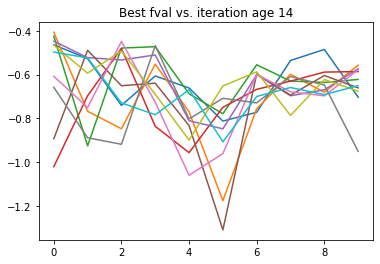

In [15]:
plt.title('Best fval vs. iteration age %d' % age)
for f_l in f_l_l:
    plt.plot(*zip(*enumerate(f_l)))
plt.show()